<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Judy/Copy_of_New_Way_for_NN_BlackScholes_Judy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import numpy as np

In [ ]:
# iv = 0.005
# rnd_s0 = np.arange(0.75, 1.25 + iv, iv)
# print(len(rnd_s0))
# initial_stocks = np.array([rnd_s0[i] for i in np.random.randint(0, len(rnd_s0)+1, 2)])
# initial_stocks

# Use Black-Scholes to Generate Data
# Construct Neural Net

In [1]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   8977      0 --:--:-- --:--:-- --:--:--  8977
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 52 kB/s 
     |████████████████████████████████| 1.0 MB 54.6 MB/s 
+ set +ex
Installation succeeded!


In [2]:
%%writefile cupy_dataset.py
import cupy
import numpy as np
from torch.utils.dlpack import from_dlpack
from scipy.stats import norm
from math import log, sqrt, pi, exp

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):

          ################################################################################################### generate random input numbers
          # intervals
          iv_s0 = (1.25-0.75)/40
          iv_sigma = (0.45-0.15)/20
          iv_r = (0.6-0.25)/20
          iv_K = (1.25-0.75)/40

          # initial_stocks = np.array(np.random.randint(75,125,self.N_STOCKS)/100)
          # iv_s0 = 0.005
          rnd_s0 = np.arange(0.75, 1.25 + iv_s0, iv_s0)
          initial_stocks = np.array([rnd_s0[i] for i in np.random.randint(0, len(rnd_s0), self.N_STOCKS)])

          corr = np.diag(np.array([1]*self.N_STOCKS)) # assume no correlation between stocks here

          # sigma = np.array(np.random.randint(15,45,self.N_STOCKS)/100)

          # iv_sigma = 0.005
          rnd_sigma = np.arange(0.15, 0.45 + iv_sigma, iv_sigma)
          sigma = np.array([rnd_sigma[i] for i in np.random.randint(0, len(rnd_sigma), self.N_STOCKS)])

          cov = (np.diag(sigma)).dot(corr).dot(np.diag(sigma))

          # r = np.repeat(np.array(np.random.randint(25,60)/100), self.N_STOCKS)
          # iv_r = 0.005
          rnd_r = np.arange(0.25, 0.6 + iv_r, iv_r)
          r = np.repeat(rnd_r[np.random.randint(0,len(rnd_r), 1)], self.N_STOCKS)

          drift = r

          T = self.T
          # K = np.random.randint(75,125)/100
          # iv_K = 0.005
          rnd_K = np.arange(0.75, 1.25 + iv_K, iv_K)
          K = rnd_K[np.random.randint(0, len(rnd_K), 1)]

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas

          European_Call_price = bs_call(initial_stocks,K,T,r,sigma)
          Deltas = bs_delta(initial_stocks,K,T,r,sigma)

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price[0]
          Y[op, 1:4] = cupy.array(Deltas, dtype=cupy.float32)

          # T, K, S, sigma, mu, r
          paras = (np.repeat(np.array(T), self.N_STOCKS), np.repeat(np.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))



# ds = OptionDataSet(max_len = 2, number_path = 1000000, batch = 2, seed = np.random.randint(10000), stocks=1) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Writing cupy_dataset.py


In [3]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, 32) # remember to change this!
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.3, 0.35, 0.35]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.75, 0.15, 0.25, 0.25]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [4]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 13.4 MB/s 


In [6]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 100000, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  if __name__ == '__main__':


loss 0.4013029932975769 average time 0.08613701149999713 iter num 20
loss 0.353458046913147 average time 0.06141945704999898 iter num 40
loss 0.35862645506858826 average time 0.05241714796666533 iter num 60
loss 0.35201123356819153 average time 0.048421261774999634 iter num 80
loss 0.34865322709083557 average time 0.046085699239999084 iter num 100
loss 0.3247876763343811 average time 0.0366212336000018 iter num 20
loss 0.27069368958473206 average time 0.03573230165000254 iter num 40
loss 0.22938567399978638 average time 0.03580732048333554 iter num 60
loss 0.22726371884346008 average time 0.03560913260000156 iter num 80
loss 0.2056218981742859 average time 0.03524693991000191 iter num 100
loss 0.16648226976394653 average time 0.03788804240000019 iter num 20
loss 0.10943172872066498 average time 0.036452972250000215 iter num 40
loss 0.06066231057047844 average time 0.03567911195000022 iter num 60
loss 0.04919721558690071 average time 0.03562074707499896 iter num 80
loss 0.05054866150021

State:
	iteration: 10000
	epoch: 100
	epoch_length: 100
	max_epochs: 100
	output: 0.0002621753665152937
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'cupy_dataset.OptionDataSet'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

9 min

# Save Model

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import torch
model_save_name = 'jax_european_1stock_grid_6.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

# Load Model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import torch
model_save_name = 'jax_european_1stock_grid_6.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [8]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
)


In [15]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 2000000, batch = 64, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 10

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 500)

#model_save_name = 'jax_european_1stock_grid_1.pth'
#path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
#torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  """


loss 3.400162313482724e-05 average time 0.14665030400001342 iter num 10
loss 1.2672445336647797e-05 average time 0.10548695080002517 iter num 20
loss 2.759971539489925e-05 average time 0.09004501823335431 iter num 30
loss 1.3968136045150459e-05 average time 0.08250313700002039 iter num 40
loss 6.41399747109972e-05 average time 0.07842139744000633 iter num 50
loss 1.4055164683668409e-05 average time 0.07524044830000397 iter num 60
loss 1.575926762598101e-05 average time 0.07343884915714755 iter num 70
loss 1.0972500604111701e-05 average time 0.07177783358750105 iter num 80
loss 1.1998756235698238e-05 average time 0.0706791180888912 iter num 90
loss 7.781590284139384e-06 average time 0.06989238467000178 iter num 100
loss 2.266401133965701e-05 average time 0.06459368569996968 iter num 10
loss 1.2823545148421545e-05 average time 0.06234844445001499 iter num 20
loss 6.253624178498285e-06 average time 0.06169581193333518 iter num 30
loss 1.7884809494717047e-05 average time 0.0611399113250115

State:
	iteration: 50000
	epoch: 500
	epoch_length: 100
	max_epochs: 500
	output: 8.9173590822611e-06
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'cupy_dataset.OptionDataSet'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

10 + 10+ 47min + 1hr30min

# Results

In [10]:
import torch
inputs = torch.tensor([[1, 1, 1, 0.25, 0.3, 0.3]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.27130044, 0.90763223)

price: tensor([[0.2710]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([0.9102], device='cuda:0')

# Delta

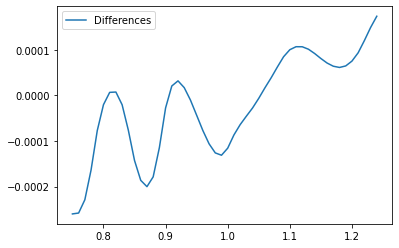

In [18]:
import numpy as np
from scipy.stats import norm
from math import log, sqrt, pi, exp
import matplotlib.pyplot as plt

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def compute_price(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.3, 0.3]]).cuda()
    return model(inputs.float())

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
BS_call_prices = []
for p in prices:
    model_call_prices.append(compute_price(p).item())
    BS_call_prices.append(bs_call(p, 1, 1, 0.3, 0.25))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, BS_call_prices, label = "BS_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(BS_call_prices), label = "Differences")
plt.legend()
plt.show()

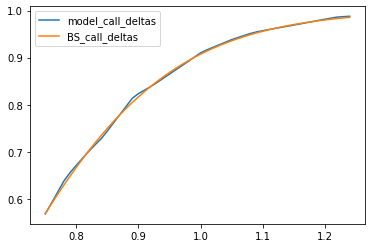

In [19]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.3, 0.3]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1, 1, 0.3, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()


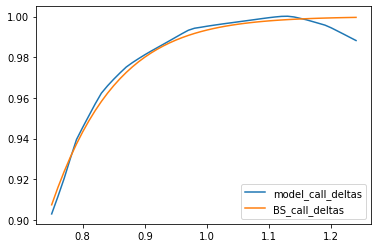

In [20]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.75, S, 0.25, 0.3, 0.3]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 0.75, 1, 0.3, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()


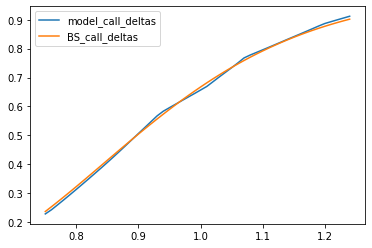

In [21]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1.25, S, 0.25, 0.3, 0.3]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1.25, 1, 0.3, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()
